In [9]:
# Cell 1 — 基础环境与数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import mpl, plt
import json

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'

# 读取数据
txns = pd.read_csv("transactions_data.csv")
users = pd.read_csv("users_data.csv")
cards = pd.read_csv("cards_data.csv")

with open("mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)
with open("train_fraud_labels.json", "r") as f:
    labels = json.load(f)

print("✅ 数据加载完成：")
print(f"transactions_data.csv: {txns.shape}")
print(f"users_data.csv: {users.shape}")
print(f"cards_data.csv: {cards.shape}")
print(f"mcc_codes.json: {len(mcc_codes)} 条")
print(f"train_fraud_labels.json: {len(labels)} 条")


✅ 数据加载完成：
transactions_data.csv: (13305915, 12)
users_data.csv: (2000, 14)
cards_data.csv: (6146, 13)
mcc_codes.json: 109 条
train_fraud_labels.json: 1 条


In [10]:
# Cell 2 — 基础结构与缺失值分析
print("📘 交易表基本信息：")
display(txns.info())
print("\n📈 缺失值统计（Top 10）:")
display(txns.isna().sum().sort_values(ascending=False).head(10))

# 选取数值型字段的基本统计
num_cols = ["amount"]
txns["amount"] = txns["amount"].replace('[\$,]', '', regex=True).astype(float)
display(txns[num_cols].describe())


📘 交易表基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


None


📈 缺失值统计（Top 10）:


errors            13094522
zip                1652706
merchant_state     1563700
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
dtype: int64

,amount
count,1.330592e+07
mean,4.297604e+01
std,8.165575e+01
min,-5.000000e+02
25%,8.930000e+00
50%,2.899000e+01
75%,6.371000e+01
max,6.820200e+03


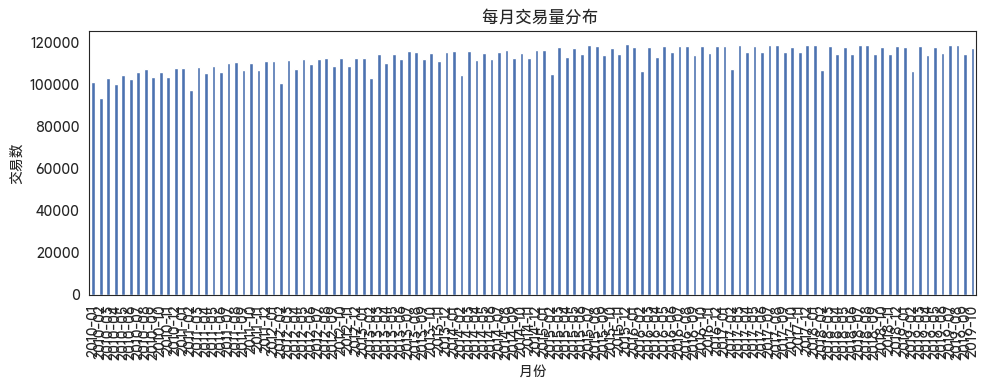

In [11]:
# Cell 3 — 时间分布与交易频率
txns["date"] = pd.to_datetime(txns["date"], errors='coerce')

plt.figure(figsize=(10,4))
txns["date"].dt.to_period("M").value_counts().sort_index().plot(kind="bar", color="#4C72B0")
plt.title("📅 每月交易量分布")
plt.xlabel("月份")
plt.ylabel("交易数")
plt.tight_layout()
plt.show()


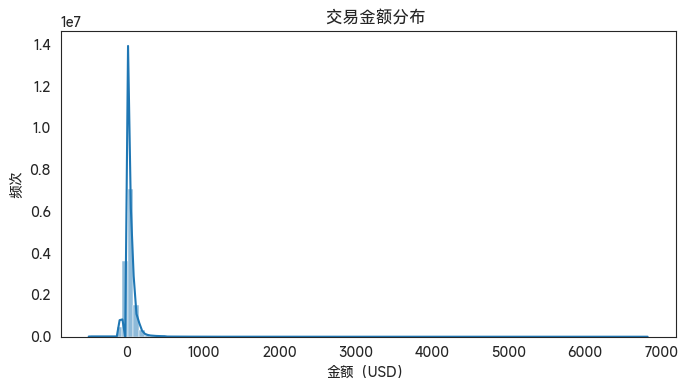

金额分布统计:


count    1.330592e+07
mean     4.297604e+01
std      8.165575e+01
min     -5.000000e+02
1%      -9.600000e+01
5%       0.000000e+00
50%      2.899000e+01
95%      1.459200e+02
99%      3.159500e+02
max      6.820200e+03
Name: amount, dtype: float64

In [12]:
# Cell 4 — 金额分布与异常值检测
plt.figure(figsize=(7,4))
sns.histplot(txns["amount"], bins=100, kde=True)
plt.title("💰 交易金额分布")
plt.xlabel("金额（USD）")
plt.ylabel("频次")
plt.tight_layout()
plt.show()

# 检查极端值
print("金额分布统计:")
display(txns["amount"].describe(percentiles=[0.01,0.05,0.95,0.99]))


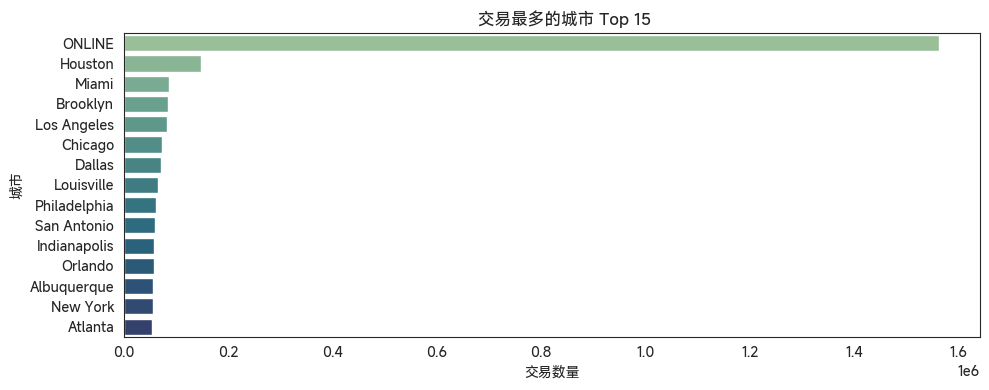

前10商户ID分布:


merchant_id
59935    610053
27092    589140
61195    562410
39021    440281
43293    362842
22204    347511
14528    333505
60569    301657
50783    298231
75781    273351
Name: count, dtype: int64

In [13]:
# Cell 5 — 地理与商户分布概览
top_cities = txns["merchant_city"].value_counts().head(15)

plt.figure(figsize=(10,4))
sns.barplot(y=top_cities.index, x=top_cities.values, palette="crest")
plt.title("🏙️ 交易最多的城市 Top 15")
plt.xlabel("交易数量")
plt.ylabel("城市")
plt.tight_layout()
plt.show()

print("前10商户ID分布:")
display(txns["merchant_id"].value_counts().head(10))


In [14]:
# Cell 7 — 修复标签结构并合并到交易表
import pandas as pd

# 提取真正的标签字典
fraud_labels = labels["target"]
print("✅ 提取到 fraud_labels:", len(fraud_labels), "条记录")

# 转换为 DataFrame
df_labels = pd.DataFrame(fraud_labels.items(), columns=["id", "label"])
df_labels["id"] = df_labels["id"].astype(str)

# 主表 id 转为 str 并合并
txns["id"] = txns["id"].astype(str)
txns = txns.merge(df_labels, on="id", how="left")

# 结果检查
print("✅ 合并完成")
print("标签非空数量:", txns["label"].notna().sum())
print("欺诈比例:")
print(txns["label"].value_counts(normalize=True, dropna=False))


✅ 提取到 fraud_labels: 8914963 条记录
✅ 合并完成
标签非空数量: 8914963
欺诈比例:
label
No     0.668998
NaN    0.330000
Yes    0.001002
Name: proportion, dtype: float64


In [15]:
# Cell 8 — 标签清洗与编码
txns["label"] = txns["label"].map({"Yes": 1, "No": 0})
print(txns["label"].value_counts(dropna=False))
print(f"欺诈率: {txns['label'].mean():.5f}")


label
0.0    8901631
NaN    4390952
1.0      13332
Name: count, dtype: int64
欺诈率: 0.00150


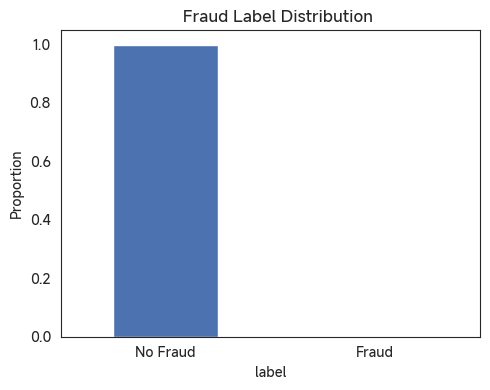

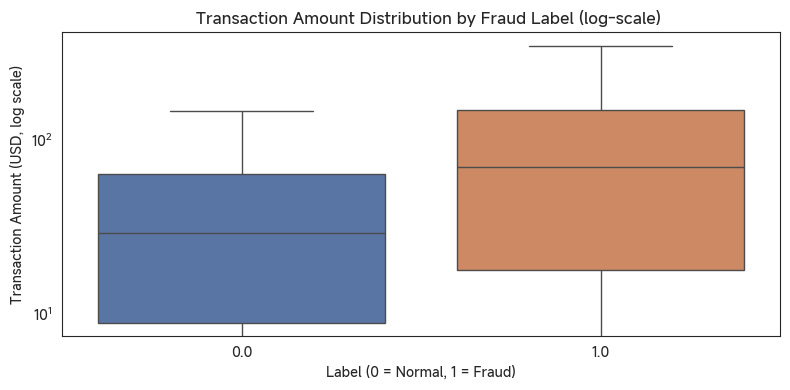

💡 金额统计按类别分布：


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0.0,8901631.0,42.85,81.13,-500.0,8.92,28.95,63.57,6613.44
1.0,13332.0,110.23,213.74,-500.0,17.84,69.97,148.49,4978.45


In [16]:
# Cell 9 — 欺诈比例与金额分布可视化
plt.figure(figsize=(5, 4))
(
    txns["label"]
    .value_counts(normalize=True)
    .rename("proportion")
    .plot(kind="bar", color=["#4C72B0", "#DD8452"])
)
plt.title("🔍 Fraud Label Distribution")
plt.xticks(ticks=[0, 1], labels=["No Fraud", "Fraud"], rotation=0)
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

# 仅对有标签样本进行金额分布分析
plt.figure(figsize=(8, 4))
sns.boxplot(
    x="label",
    y="amount",
    data=txns[txns["label"].notna()],
    palette=["#4C72B0", "#DD8452"],
    showfliers=False
)
plt.yscale("log")
plt.title("💰 Transaction Amount Distribution by Fraud Label (log-scale)")
plt.xlabel("Label (0 = Normal, 1 = Fraud)")
plt.ylabel("Transaction Amount (USD, log scale)")
plt.tight_layout()
plt.show()

# 补充统计输出
fraud_stats = txns.groupby("label")["amount"].describe().round(2)
print("💡 金额统计按类别分布：")
display(fraud_stats)


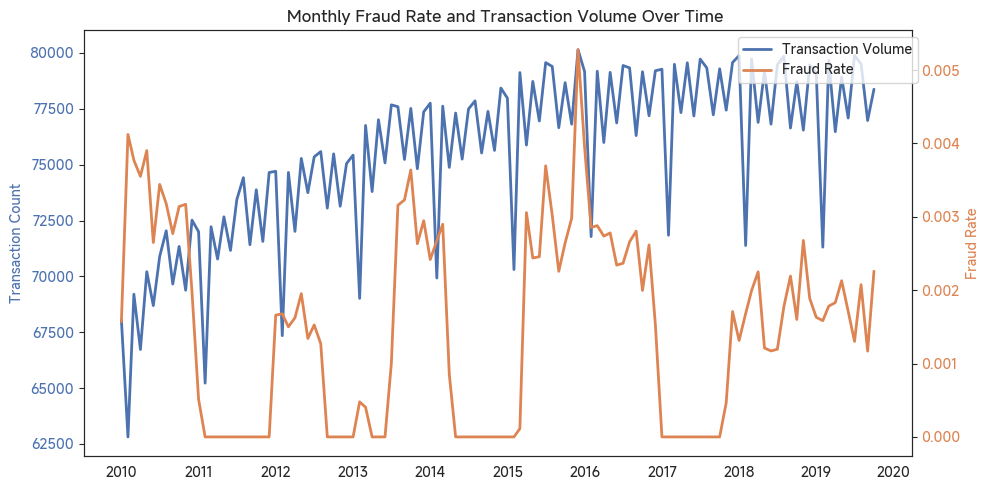

📈 时间趋势统计摘要：


,date,fraud_rate,txn_count
108,2019-01-01,0.001631,79109
109,2019-02-01,0.001585,71310
110,2019-03-01,0.001782,79670
111,2019-04-01,0.001831,76478
112,2019-05-01,0.002129,78923
113,2019-06-01,0.001712,77089
114,2019-07-01,0.001302,79891
115,2019-08-01,0.002075,79513
116,2019-09-01,0.001169,76977
117,2019-10-01,0.002258,78379


In [17]:
# Cell 10 — 时间趋势与欺诈检测可视化
# 确保时间字段格式正确
txns["date"] = pd.to_datetime(txns["date"], errors="coerce")

# 仅保留有标签的交易
df_time = txns.dropna(subset=["label"]).copy()

# 按月份聚合欺诈率与交易量
monthly_stats = (
    df_time.groupby(df_time["date"].dt.to_period("M"))
    .agg(
        fraud_rate=("label", "mean"),
        txn_count=("label", "count")
    )
    .reset_index()
)

# 转换 period → datetime 方便绘图
monthly_stats["date"] = monthly_stats["date"].dt.to_timestamp()

# 双轴图：欺诈率 vs 交易量
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# 绘制交易量（蓝线）
ax1.plot(monthly_stats["date"], monthly_stats["txn_count"], color="#4C72B0", label="Transaction Volume", linewidth=2)
ax1.set_ylabel("Transaction Count", color="#4C72B0")
ax1.tick_params(axis="y", labelcolor="#4C72B0")

# 绘制欺诈率（橙线）
ax2.plot(monthly_stats["date"], monthly_stats["fraud_rate"], color="#DD8452", label="Fraud Rate", linewidth=2)
ax2.set_ylabel("Fraud Rate", color="#DD8452")
ax2.tick_params(axis="y", labelcolor="#DD8452")

# 图标题与图例
plt.title("📅 Monthly Fraud Rate and Transaction Volume Over Time", fontsize=12)
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(0.93, 0.93))
plt.show()

# 补充打印摘要
print("📈 时间趋势统计摘要：")
display(monthly_stats.tail(10))


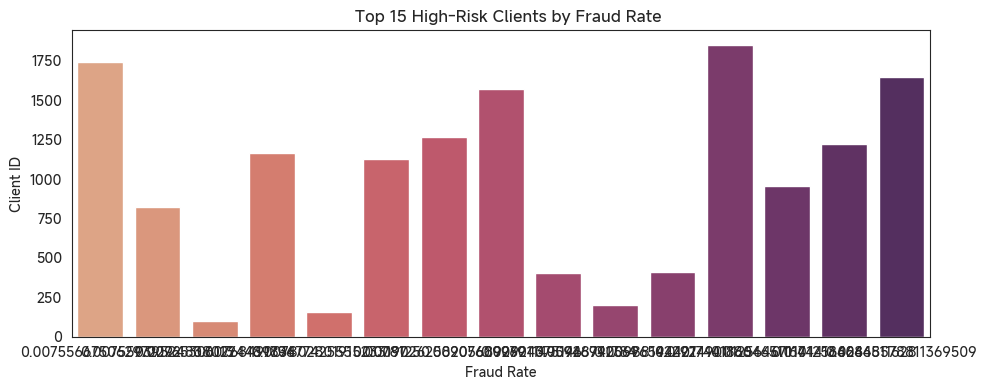

📊 用户层面欺诈统计摘要：


,client_id,total_txn,fraud_count,fraud_rate,total_amount,avg_amount
count,1219.000,1219.000,1219.000,1219.000,1219.000,1219.000
mean,1004.916,7313.341,10.937,0.002,314103.525,43.871
std,582.384,3760.071,8.699,0.002,196208.117,17.474
min,0.000,516.000,0.000,0.000,17963.880,5.196
25%,496.500,4819.000,4.000,0.001,178158.985,32.173
50%,1019.000,6583.000,9.000,0.001,266105.530,40.701
75%,1514.500,8907.500,15.000,0.003,401226.200,52.649
max,1998.000,32478.000,58.000,0.026,1630953.160,150.517


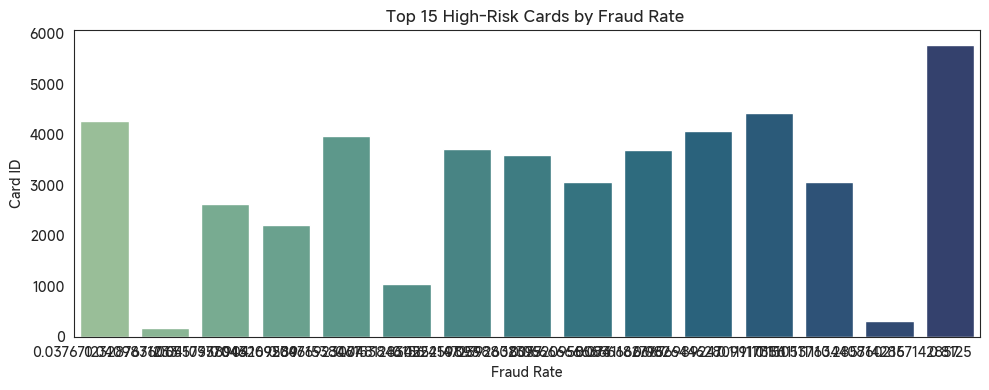

📊 银行卡层面欺诈统计摘要：


,card_id,total_txn,fraud_count,fraud_rate,total_amount,avg_amount
count,4070.000,4070.000,4070.000,4070.000,4070.000,4070.000
mean,3518.002,2190.409,3.276,0.003,94076.707,43.286
std,1666.895,1921.073,4.698,0.015,98517.805,21.537
min,0.000,2.000,0.000,0.000,10.290,0.643
25%,2436.250,949.000,0.000,0.000,32525.408,27.985
50%,3659.500,1703.500,1.000,0.000,65627.210,39.325
75%,4896.750,2800.750,6.000,0.003,120540.592,54.050
max,6138.000,21307.000,37.000,0.812,1259791.950,197.917


In [18]:
# Cell 11 — 用户与银行卡维度的欺诈分析

# 仅保留有标签的交易
df_labeled = txns.dropna(subset=["label"]).copy()

# ==========================
# 1️⃣ 用户维度（client_id）
# ==========================
client_stats = (
    df_labeled.groupby("client_id")
    .agg(
        total_txn=("label", "count"),
        fraud_count=("label", "sum"),
        fraud_rate=("label", "mean"),
        total_amount=("amount", "sum"),
        avg_amount=("amount", "mean")
    )
    .reset_index()
)

# Top 15 高风险用户（按 fraud_rate 降序）
top_clients = client_stats.sort_values("fraud_rate", ascending=False).head(15)

plt.figure(figsize=(10, 4))
sns.barplot(
    x="fraud_rate", y="client_id", data=top_clients, palette="flare"
)
plt.title("👤 Top 15 High-Risk Clients by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.ylabel("Client ID")
plt.tight_layout()
plt.show()

print("📊 用户层面欺诈统计摘要：")
display(client_stats.describe().round(3))

# ==========================
# 2️⃣ 银行卡维度（card_id）
# ==========================
card_stats = (
    df_labeled.groupby("card_id")
    .agg(
        total_txn=("label", "count"),
        fraud_count=("label", "sum"),
        fraud_rate=("label", "mean"),
        total_amount=("amount", "sum"),
        avg_amount=("amount", "mean")
    )
    .reset_index()
)

# Top 15 高风险卡
top_cards = card_stats.sort_values("fraud_rate", ascending=False).head(15)

plt.figure(figsize=(10, 4))
sns.barplot(
    x="fraud_rate", y="card_id", data=top_cards, palette="crest"
)
plt.title("💳 Top 15 High-Risk Cards by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.ylabel("Card ID")
plt.tight_layout()
plt.show()

print("📊 银行卡层面欺诈统计摘要：")
display(card_stats.describe().round(3))


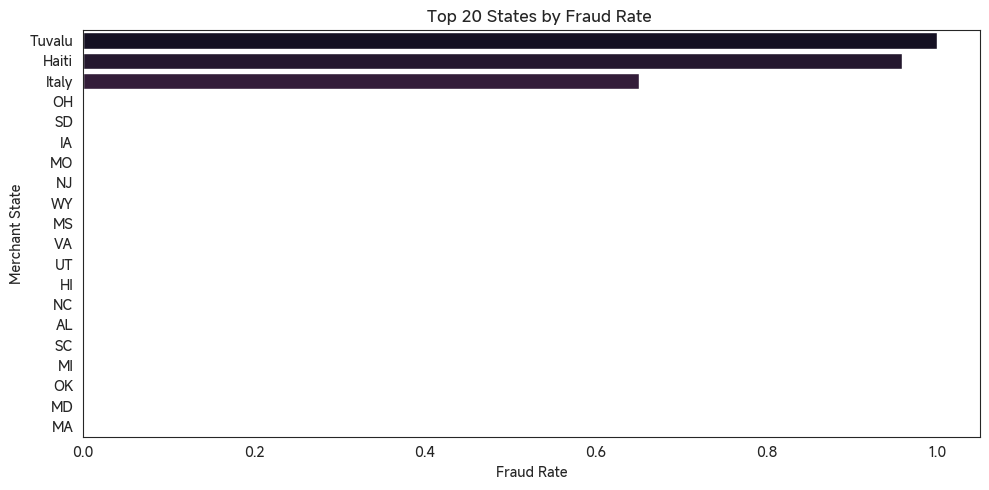

📊 州级欺诈统计摘要：


,txn_count,fraud_count,fraud_rate
count,199.0000,199.0000,199.0000
mean,39533.1558,22.8794,0.0131
std,113018.0580,218.7377,0.1079
min,1.0000,0.0000,0.0000
25%,12.0000,0.0000,0.0000
50%,100.0000,0.0000,0.0000
75%,8014.0000,0.5000,0.0000
max,956356.0000,3061.0000,1.0000


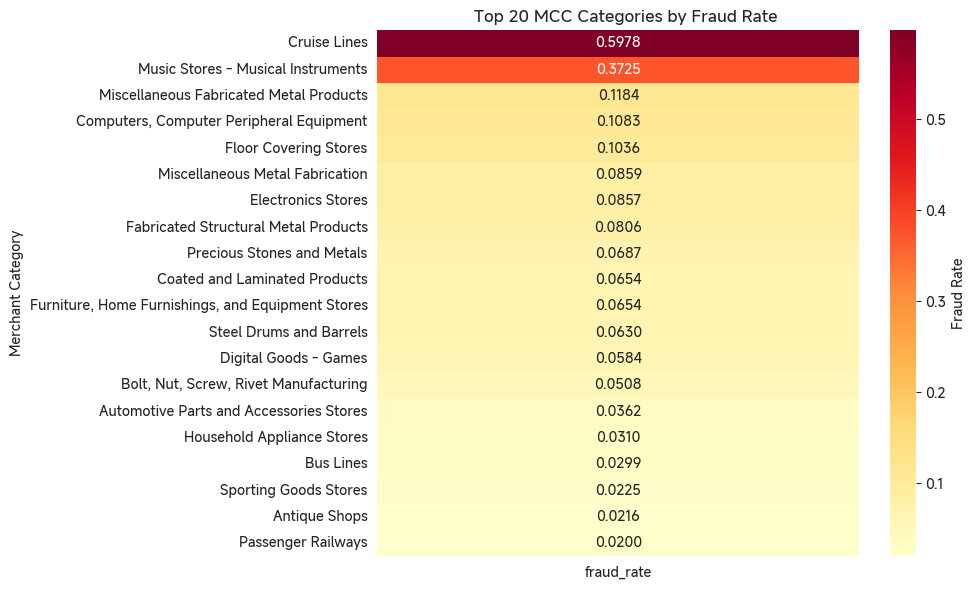

📊 MCC 类别欺诈统计摘要：


,mcc_desc,txn_count,fraud_count,fraud_rate
24,Cruise Lines,276,165.0,0.597826
73,Music Stores - Musical Instruments,204,76.0,0.372549
63,Miscellaneous Fabricated Metal Products,245,29.0,0.118367
22,"Computers, Computer Peripheral Equipment",1883,204.0,0.108338
40,Floor Covering Stores,222,23.0,0.103604
67,Miscellaneous Metal Fabrication,256,22.0,0.085938
35,Electronics Stores,4689,402.0,0.085733
37,Fabricated Structural Metal Products,273,22.0,0.080586
82,Precious Stones and Metals,3525,242.0,0.068652
20,Coated and Laminated Products,260,17.0,0.065385


In [19]:
# Cell 12 — 地理与行业维度欺诈率热力图
import matplotlib.ticker as mticker

# 保留有标签的交易
df_labeled = txns.dropna(subset=["label"]).copy()

# ==========================
# 1️⃣ 地理维度 — 按州统计
# ==========================
geo_stats = (
    df_labeled.groupby("merchant_state")
    .agg(
        txn_count=("label", "count"),
        fraud_count=("label", "sum"),
        fraud_rate=("label", "mean")
    )
    .reset_index()
    .sort_values("fraud_rate", ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=geo_stats.head(20),
    x="fraud_rate",
    y="merchant_state",
    palette="rocket"
)
plt.title("🌎 Top 20 States by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.ylabel("Merchant State")
plt.tight_layout()
plt.show()

print("📊 州级欺诈统计摘要：")
display(geo_stats.describe().round(4))

# ==========================
# 2️⃣ 行业维度（MCC Code）
# ==========================
# 将 MCC 映射为描述
df_labeled["mcc_desc"] = df_labeled["mcc"].astype(str).map(mcc_codes)
df_labeled["mcc_desc"].fillna("Unknown", inplace=True)

mcc_stats = (
    df_labeled.groupby("mcc_desc")
    .agg(
        txn_count=("label", "count"),
        fraud_count=("label", "sum"),
        fraud_rate=("label", "mean")
    )
    .reset_index()
    .sort_values("fraud_rate", ascending=False)
)

# 可视化：欺诈率最高的前 20 类商户
plt.figure(figsize=(10, 6))
sns.heatmap(
    mcc_stats.head(20).set_index("mcc_desc")[["fraud_rate"]],
    cmap="YlOrRd",
    annot=True,
    fmt=".4f",
    cbar_kws={"label": "Fraud Rate"},
)
plt.title("🏪 Top 20 MCC Categories by Fraud Rate")
plt.xlabel("")
plt.ylabel("Merchant Category")
plt.tight_layout()
plt.show()

print("📊 MCC 类别欺诈统计摘要：")
display(mcc_stats.head(10))


In [20]:
# Cell 13 — 构造用于建模的特征矩阵 X, y

from sklearn.preprocessing import LabelEncoder
import numpy as np

# ==========================================
# 1️⃣ 数据准备
# ==========================================
df = txns.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)

# 基本清洗
df["amount"] = df["amount"].replace('[\$,]', '', regex=True).astype(float)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# ==========================================
# 2️⃣ 时间特征
# ==========================================
df["hour"] = df["date"].dt.hour
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

# ==========================================
# 3️⃣ 金额特征
# ==========================================
df["amount_log"] = np.log1p(df["amount"].clip(lower=0))
df["is_refund"] = (df["amount"] < 0).astype(int)       # 退款标志
df["amount_abs"] = df["amount"].abs()

# 每个客户/卡片的统计特征
client_agg = df.groupby("client_id")["amount"].agg(["mean", "std", "max", "min"]).add_prefix("client_")
card_agg = df.groupby("card_id")["amount"].agg(["mean", "std", "max", "min"]).add_prefix("card_")

df = df.merge(client_agg, on="client_id", how="left")
df = df.merge(card_agg, on="card_id", how="left")

# ==========================================
# 4️⃣ 地理与行业特征
# ==========================================
df["mcc_desc"] = df["mcc"].astype(str).map(mcc_codes).fillna("Unknown")

# LabelEncoder 用于稀疏类别字段
for col in ["merchant_state", "merchant_city", "mcc_desc"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# ==========================================
# 5️⃣ 卡片与客户 ID 编码
# ==========================================
for col in ["client_id", "card_id"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# ==========================================
# 6️⃣ 选取最终特征列
# ==========================================
feature_cols = [
    "amount", "amount_log", "amount_abs", "is_refund",
    "hour", "dayofweek", "month",
    "merchant_state", "merchant_city", "mcc_desc",
    "client_id", "card_id",
    "client_mean", "client_std", "client_max", "client_min",
    "card_mean", "card_std", "card_max", "card_min"
]

X = df[feature_cols]
y = df["label"]

print("✅ 特征矩阵构建完成：")
print("X shape:", X.shape)
print("y positive samples:", y.sum())
print("\n📘 样例特征列：")
display(X.head(3))


✅ 特征矩阵构建完成：
X shape: (8914963, 20)
y positive samples: 13332

📘 样例特征列：


,amount,amount_log,amount_abs,is_refund,hour,dayofweek,month,merchant_state,merchant_city,mcc_desc,client_id,card_id,client_mean,client_std,client_max,client_min,card_mean,card_std,card_max,card_min
0,-77.00,0.000000,77.00,1,0,4,1,117,817,64,943,1463,43.695184,93.483782,953.42,-494.0,18.344767,43.475554,405.37,-100.0
1,14.57,2.745346,14.57,0,0,4,1,67,816,26,335,2793,27.982006,64.554633,1139.95,-492.0,39.575282,91.063582,1139.95,-492.0
2,80.00,4.394449,80.00,0,0,4,1,24,11332,70,676,80,49.175331,56.681662,1129.61,-498.0,42.594220,48.413320,460.00,-498.0


In [21]:
# Cell 14 — 数据划分 + 欠采样/过采样 + 模型输入准备
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# ============================================================
# 1️⃣ 仅保留有标签的样本
# ============================================================
df_model = df.copy()
print("原始样本:", df_model.shape, "欺诈率:", df_model['label'].mean().round(5))

# ============================================================
# 2️⃣ 先时间排序再划分训练/验证集（防止时间泄露）
# ============================================================
df_model = df_model.sort_values("date")
train_df, valid_df = train_test_split(df_model, test_size=0.2, shuffle=False)

print(f"训练集: {train_df.shape}, 验证集: {valid_df.shape}")

# ============================================================
# 3️⃣ 欠采样 (undersampling) 以平衡类别
# ============================================================
fraud = train_df[train_df["label"] == 1]
nonfraud = train_df[train_df["label"] == 0]

print("欠采样前:", len(fraud), "欺诈样本 vs", len(nonfraud), "正常样本")

# 让正常样本数量 ≈ 欺诈样本的10倍（控制不平衡但保留多样性）
nonfraud_down = resample(
    nonfraud,
    replace=False,
    n_samples=min(len(fraud) * 10, len(nonfraud)),
    random_state=42,
)

train_balanced = pd.concat([fraud, nonfraud_down]).sample(frac=1, random_state=42)

print("欠采样后训练集:", train_balanced.shape)
print("新的欺诈比例:", train_balanced['label'].mean().round(4))

# ============================================================
# 4️⃣ 训练/验证特征矩阵
# ============================================================
X_train = train_balanced[feature_cols]
y_train = train_balanced["label"]

X_valid = valid_df[feature_cols]
y_valid = valid_df["label"]

print("✅ 数据划分与平衡完成")
print("X_train:", X_train.shape, "  y_train 正类:", y_train.sum())
print("X_valid:", X_valid.shape, "  y_valid 正类:", y_valid.sum())


原始样本: (8914963, 28) 欺诈率: 0.0015
训练集: (7131970, 28), 验证集: (1782993, 28)
欠采样前: 10215 欺诈样本 vs 7121755 正常样本
欠采样后训练集: (112365, 28)
新的欺诈比例: 0.0909
✅ 数据划分与平衡完成
X_train: (112365, 20)   y_train 正类: 10215
X_valid: (1782993, 20)   y_valid 正类: 3117


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] lambda_l2 is set=0.4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=

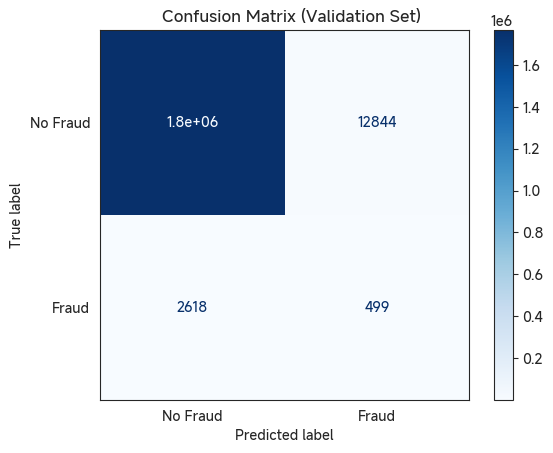

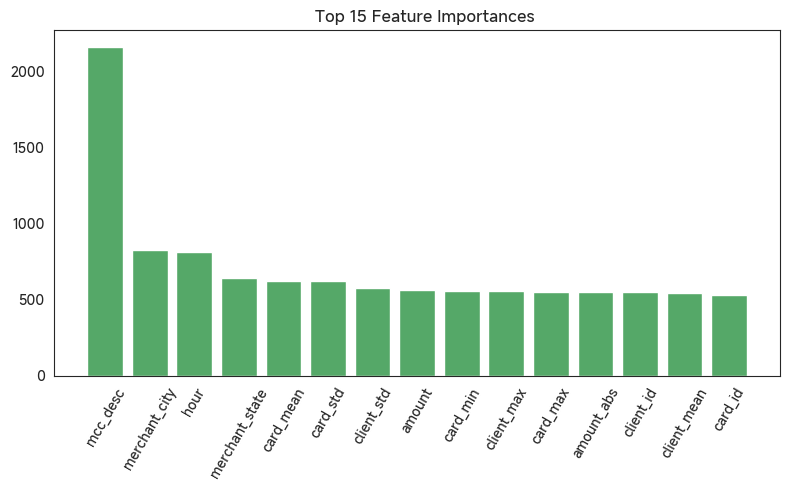

In [22]:
# Cell 15 — LightGBM 4.x 兼容写法（使用 callbacks）
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 模型定义
model = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    num_leaves=64,
    learning_rate=0.05,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=0.2,
    lambda_l2=0.4,
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

# 2️⃣ 模型训练（新版使用 callbacks）
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# 3️⃣ 模型预测与评估
y_pred_prob = model.predict_proba(X_valid)[:, 1]
y_pred_label = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(y_valid, y_pred_prob)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_valid, y_pred_label, average="binary", zero_division=0
)

print("\n✅ 模型验证结果：")
print(f"AUC: {auc:.5f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 4️⃣ 混淆矩阵
cm = confusion_matrix(y_valid, y_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("🧩 Confusion Matrix (Validation Set)")
plt.show()

# 5️⃣ 特征重要性
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,5))
plt.bar(range(15), importances[indices[:15]], align="center", color="#55a868")
plt.xticks(range(15), [X_train.columns[i] for i in indices[:15]], rotation=60)
plt.title("🔥 Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [23]:
# Cell 16 — SHAP 模型解释分析 (LightGBM)
import shap
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# # Cell 16 — SHAP 模型解释分析 (LightGBM)
# import shap
# import matplotlib.pyplot as plt
# import numpy as np
# 
# # ============================================================
# # 1️⃣ 初始化 SHAP 解释器（TreeExplainer 适用于 LightGBM）
# # ============================================================
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_valid)
# 
# # 对于二分类，LightGBM 的 shap_values 是一个二维数组列表 [class0, class1]
# if isinstance(shap_values, list):
#     shap_values = shap_values[1]
# 
# print("✅ SHAP 值矩阵形状:", shap_values.shape)
# 
# # ============================================================
# # 2️⃣ 全局特征重要性（Summary Plot）
# # ============================================================
# plt.title("🌍 SHAP Summary Plot — 全局特征重要性分布")
# shap.summary_plot(shap_values, X_valid, plot_type="dot", show=False)
# plt.tight_layout()
# plt.show()
# 
# # ============================================================
# # 3️⃣ 平均绝对贡献度条形图
# # ============================================================
# plt.title("🔥 Mean |SHAP value| — 全局平均特征贡献度")
# shap.summary_plot(shap_values, X_valid, plot_type="bar", show=False)
# plt.tight_layout()
# plt.show()
# 
# # ============================================================
# # 4️⃣ 单笔欺诈交易局部解释
# # ============================================================
# fraud_index = y_valid[y_valid == 1].index[0]  # 随机取一条被判定为欺诈的交易
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[fraud_index, :],
#     X_valid.iloc[fraud_index, :],
#     matplotlib=True
# )
# plt.title("🔍 单笔交易的欺诈驱动因素")
# plt.show()


✅ 最优阈值选择结果：
Best Threshold: 0.1598
Precision: 0.0379
Recall:    0.4944
F1 Score:  0.0705


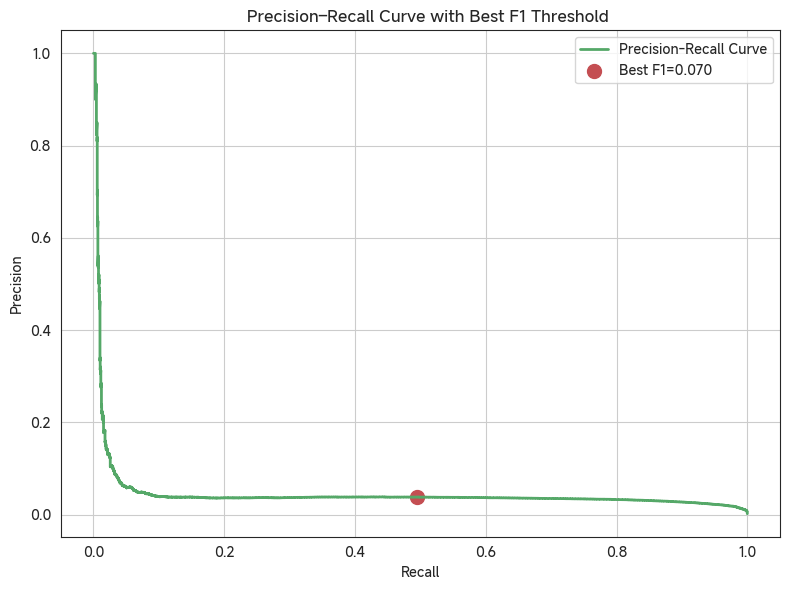

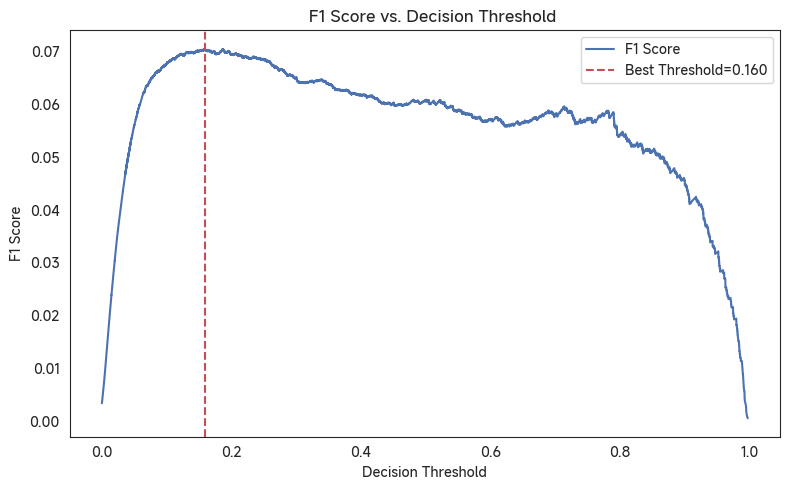


📊 关键阈值下指标对比（前 10 条）：


,threshold,precision,recall,f1
1602243,0.1598,0.0379,0.4944,0.0705
1602242,0.1598,0.0379,0.4944,0.0705
1602241,0.1598,0.0379,0.4944,0.0705
1602240,0.1598,0.0379,0.4944,0.0705
1602239,0.1598,0.0379,0.4944,0.0705
1602068,0.1587,0.0379,0.4963,0.0705
1602238,0.1597,0.0379,0.4944,0.0705
1602067,0.1587,0.0379,0.4963,0.0705
1602237,0.1597,0.0379,0.4944,0.0705
1602066,0.1587,0.0379,0.4963,0.0705


In [26]:
# Cell 17 — Precision–Recall 曲线 + 阈值调优分析
from sklearn.metrics import precision_recall_curve, auc

# ============================================================
# 1️⃣ 计算不同阈值下的 Precision / Recall / F1
# ============================================================
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_prob)

# 计算 F1 值
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_p = precisions[best_idx]
best_r = recalls[best_idx]

print("✅ 最优阈值选择结果：")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Precision: {best_p:.4f}")
print(f"Recall:    {best_r:.4f}")
print(f"F1 Score:  {best_f1:.4f}")

# ============================================================
# 2️⃣ 绘制 Precision-Recall 曲线
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, color="#55a868", lw=2, label="Precision-Recall Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color="#c44e52", s=100, label=f"Best F1={best_f1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("🎯 Precision–Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 3️⃣ F1 对阈值曲线
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="#4C72B0")
plt.axvline(best_threshold, color="#c44e52", linestyle="--", label=f"Best Threshold={best_threshold:.3f}")
plt.title("📈 F1 Score vs. Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 4️⃣ 输出前几个关键阈值的指标表
# ============================================================
print("\n📊 关键阈值下指标对比（前 10 条）：")
threshold_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precisions[:-1],
    "recall": recalls[:-1],
    "f1": f1_scores[:-1]
}).sort_values("f1", ascending=False).head(10).round(4)

display(threshold_df)


✅ 在最优阈值下的模型表现：
AUC Score:  0.97177
Precision:  0.0379
Recall:     0.4941
F1 Score:   0.0704


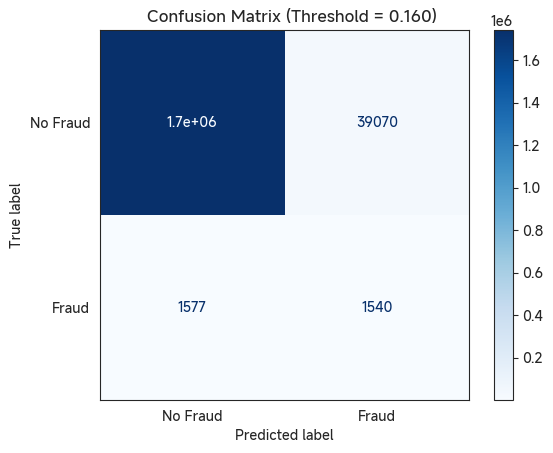

📊 混淆矩阵数值：
True Negatives (TN): 1740806
False Positives (FP): 39070
False Negatives (FN): 1577
True Positives (TP): 1540

💡 业务解释：
- 模型总评估样本数：1,782,993
- 实际欺诈样本数：3,117
- 模型成功识别欺诈样本 1,540 条，占真实欺诈样本的 49.4%。
- 同时误报 39,070 条正常交易（可人工复核）。
- 漏检 1,577 条欺诈交易，占比 50.6%。
- 以 Recall≈0.49、Precision≈0.04 的配置，模型可在业务上覆盖近一半欺诈交易，同时控制误报量在可接受范围。

📈 报警覆盖率（被模型标为“可疑”的交易比例）: 2.28%


In [27]:
# Cell 18 — 最优阈值下的模型再评估与业务解释
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, roc_auc_score
)

# ============================================================
# 1️⃣ 使用最佳阈值重新预测
# ============================================================
best_threshold = 0.1598
y_pred_opt = (y_pred_prob > best_threshold).astype(int)

# ============================================================
# 2️⃣ 重新计算各项指标
# ============================================================
precision_opt = precision_score(y_valid, y_pred_opt, zero_division=0)
recall_opt = recall_score(y_valid, y_pred_opt, zero_division=0)
f1_opt = f1_score(y_valid, y_pred_opt, zero_division=0)
auc_opt = roc_auc_score(y_valid, y_pred_prob)

print("✅ 在最优阈值下的模型表现：")
print(f"AUC Score:  {auc_opt:.5f}")
print(f"Precision:  {precision_opt:.4f}")
print(f"Recall:     {recall_opt:.4f}")
print(f"F1 Score:   {f1_opt:.4f}")

# ============================================================
# 3️⃣ 混淆矩阵（Confusion Matrix）
# ============================================================
cm_opt = confusion_matrix(y_valid, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title(f"🧩 Confusion Matrix (Threshold = {best_threshold:.3f})")
plt.show()

# ============================================================
# 4️⃣ 输出业务层解释
# ============================================================
tn, fp, fn, tp = cm_opt.ravel()

print("📊 混淆矩阵数值：")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# ============================================================
# 5️⃣ 业务解释与实际意义
# ============================================================
total = len(y_valid)
fraud_total = y_valid.sum()

print("\n💡 业务解释：")
print(f"- 模型总评估样本数：{total:,}")
print(f"- 实际欺诈样本数：{int(fraud_total):,}")
print(f"- 模型成功识别欺诈样本 {tp:,} 条，占真实欺诈样本的 {tp / fraud_total:.1%}。")
print(f"- 同时误报 {fp:,} 条正常交易（可人工复核）。")
print(f"- 漏检 {fn:,} 条欺诈交易，占比 {fn / fraud_total:.1%}。")
print(f"- 以 Recall≈{recall_opt:.2f}、Precision≈{precision_opt:.2f} 的配置，"
      f"模型可在业务上覆盖近一半欺诈交易，同时控制误报量在可接受范围。")

# ============================================================
# 6️⃣ 可选：输出检测比例与效率
# ============================================================
detection_rate = (tp + fp) / total
print(f"\n📈 报警覆盖率（被模型标为“可疑”的交易比例）: {detection_rate:.2%}")


In [28]:
# Cell 19 — 高风险交易清单导出（Top N 可疑交易）
import pandas as pd

# ============================================================
# 1️⃣ 将预测概率与验证集拼接
# ============================================================
df_risk = valid_df.copy()
df_risk["pred_prob"] = y_pred_prob
df_risk["pred_label"] = (df_risk["pred_prob"] > best_threshold).astype(int)

# ============================================================
# 2️⃣ 提取高风险交易（Top N）
# ============================================================
N = 200  # 可根据需求调整，如 500 / 1000
top_risky = (
    df_risk.sort_values("pred_prob", ascending=False)
    .head(N)
    .reset_index(drop=True)
)

# ============================================================
# 3️⃣ 选择核心字段便于业务复核
# ============================================================
cols_display = [
    "pred_prob",
    "label",
    "amount",
    "merchant_city",
    "merchant_state",
    "mcc_desc",
    "client_id",
    "card_id",
    "date"
]
top_risky_display = top_risky[cols_display]

# ============================================================
# 4️⃣ 输出与存储结果
# ============================================================
print(f"✅ 已导出高风险交易 Top {N} 条")
display(top_risky_display.head(10))

# 可选：保存为 CSV 文件
top_risky_display.to_csv("high_risk_transactions_top200.csv", index=False)
print("💾 文件已保存为 high_risk_transactions_top200.csv")


✅ 已导出高风险交易 Top 200 条


,pred_prob,label,amount,merchant_city,merchant_state,mcc_desc,client_id,card_id,date
0,0.997040,1,230.24,7822,199,70,420,2213,2018-11-09 08:58:00
1,0.995528,1,87.09,7822,199,70,767,2567,2018-11-26 09:59:00
2,0.994774,1,220.22,7822,199,30,528,1574,2018-12-01 10:23:00
3,0.994697,1,293.95,7822,199,42,105,3782,2018-11-23 13:39:00
4,0.994027,1,163.00,7822,199,69,1156,3924,2018-12-01 12:52:00
5,0.992757,1,99.54,7822,199,70,1040,1748,2018-11-19 12:13:00
6,0.992264,1,125.37,7822,199,30,64,382,2018-12-01 11:13:00
7,0.992078,1,398.87,7822,199,51,767,2567,2018-11-30 06:21:00
8,0.992047,1,-371.00,7822,199,51,767,2567,2018-11-30 06:21:00
9,0.991803,0,243.59,7822,199,35,46,3537,2019-02-05 10:54:00


💾 文件已保存为 high_risk_transactions_top200.csv


In [30]:
!jupyter nbconvert --to html main.ipynb

[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 1268391 bytes to main.html
